## 데이터 전처리

### 데이터 불러오기

In [1]:
# 레티나 설정을 해주면 글씨가 좀 더 선명하게 보입니다.
# 폰트의 주변이 흐릿하게 보이는 것을 방지합니다.
%config InlineBackend.figure_format = 'retina'

In [2]:
# 사전에 전처리한 파일 가져오기(특수문자, 숫자, 표 제거 및 sentence tokenization 사전에 진행)
import pandas as pd
df = pd.read_excel('final_preprocessed_1913.xlsx').drop('Unnamed: 0', axis=1)
df[:5]

,text
0,the government general of chosen department of...
1,this pamphlet gives the outline of the history...
2,the statements and statistics given in this pa...
3,the figures showing the number of schools exis...
4,the government general of chosen


In [3]:
df['text'][0]

'the government general of chosen department of internal affairs bureau of education   manual of education  of  koreans   seoul  published by authority  the second year of taisho         preface '

### 단어 토큰화

In [4]:
# NLTK의 RegexpTokenizer를 통해 단어 토큰화를 수행합니다.
import nltk
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer("[\w']+")
df['text'] = df.apply(lambda row: tokenizer.tokenize(row['text']), axis=1)

In [5]:
df['text'][0]

['the',
 'government',
 'general',
 'of',
 'chosen',
 'department',
 'of',
 'internal',
 'affairs',
 'bureau',
 'of',
 'education',
 'manual',
 'of',
 'education',
 'of',
 'koreans',
 'seoul',
 'published',
 'by',
 'authority',
 'the',
 'second',
 'year',
 'of',
 'taisho',
 'preface']

### 표제어 추출(Lemmatization)

In [6]:
# 품사 태깅 오류를 수정하기 위한 special_token 지정
special_token = {'seoul':'NN','terauchi':'NN','japan':'NN','korea':'NN', 'koreans':'NNS', 
                 'taught':'VBN', 'arts':'NNS', 'imparting':'VBG', 'exceeds':'VBZ', 
                 'belong':'VB', 'belongs':'VBZ', 'kindergartens':'NNS', 'hears':'VBZ',
                 'girls':'NNS', 'pupils':'NNS', 'boys':'NNS', 'higher':'JJR'}

In [7]:
def special_func(token):
#     print(token,token[0],token[1])
    if token[0] in list(special_token.keys()):
        token  = tuple([token[0],special_token[token[0]]])
    else:
        pass
    return token

In [8]:
# 품사를 고려한 표제어 추출을 시행합니다.
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()

# POS tag
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

tokenized_doc = df['text']
    
total_lemmmatized = []
for tokenized_sentence in tokenized_doc:
    # tokenize the sentence and find the POS tag for each token
    pos_tagged = nltk.pos_tag(tokenized_sentence)
    new_pos_tagged = [special_func(data) for data in pos_tagged]
    # As you may have noticed, the above pos tags are a little confusing.
    # we use our own pos_tagger function to make things simpler to understand.
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), new_pos_tagged))

    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            # else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    
    total_lemmmatized.append(lemmatized_sentence)

lemmatized_doc = pd.Series(total_lemmmatized)
lemmatized_doc[:5]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


0    [the, government, general, of, chosen, departm...
1    [this, pamphlet, give, the, outline, of, the, ...
2    [the, statement, and, statistic, give, in, thi...
3    [the, figure, show, the, number, of, school, e...
4               [the, government, general, of, chosen]
dtype: object

### 불용어 제거

In [9]:
# NLTK가 제공하는 영어 불용어를 및 분석자가 선정한 불용어를 합쳐 text 데이터로부터 불용어를 제거합니다.
stopwords = [
    'there',
    'more', 'than', 'most',
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves',
    'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 
    'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself',
    'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 
    'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 
    'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 
    'do', 'does', 'did', 'doing', 'a', 'an', 'the', 
    'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while',
    'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 
    'during', 'before', 'after', 'upon','besides',
    'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'among',
    'again', 'further', 'then', 'when', 'where', 'why', 'how', 
    'all', 'any', 'both', 'few', 'such', 'no', 'nor', 'not', 'only', 'own', 'so', 's', 't', 
    'can', 'will', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 
    'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 
    'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 
    'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 
    'shan', "shan't", 'shouldn', "shouldn't", 
    'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 
    'wouldn', "wouldn't", 'would', 'could', 'might', 'need', 'can', 'must', 'shall', 'may',
    'wa', 'ha', 'ho', 'b', 'h', 's', 'sh', "'s", 'e', 'k', 'n', 'c', 'p', 'th', 'tha', 'ty', 
    'I', 'II', 'III', 'IV', 'V', 'VI', 'VII', 'VIII', 'IX', 'X', 'XI', 'XII', 'XIII', 'XIV', 'XV', 
    'XVI', 'XVII', 'XVIII', 'XIX', 'XX', 'XXI', 'XXII', 'XXIII', 'XXIV', 'XXV', 'XXVI', 
    'XXVII', 'XXVIII', 'XXIX', 'XXXXXXI', 'XXXII', 'XXXIII', 'XXXIV', 'XXXV', 'XXXVI', 'XXXVII',
    'XXXVIII', 'XXXIX', 'XL', 'XLI', 'XLII', 'XLIII', 'XLIV', 'XLV', 'XLVI', 'XLVII', 'XLVIII', 
    'XLIX', 'L', 'LI', 'LII', 'LIII', 'LIV', 'LV', 'LVI', 'LVII', 'LVIII', 'LIX', 'LX', 'LXI', 
    'LXII', 'LXIII', 'LXIV', 'LXV', 'LXVI', 'LXVII', 'LXVIII', 'LXIX', 'LXX', 
    'i', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x', 'xi', 'xii', 
    'xiii', 'xiv', 'xv', 'xvi', 'xvii', 'xviii', 'xix', 'xx', 'xxx', 'xxxi', 'xxi', 
    'xxii', 'xxiii', 'xxiv', 'xxv', 'xxvi', 'xxvii', 'xxviii', 'xxix', 'xxxxxxi', 'xxxii',
    'xxxiii', 'xxxiv', 'xxxv', 'xxxvi', 'xxxvii', 'xxxviii', 'xxxix', 'xl', 'xli', 'xlii', 
    'xliii', 'xliv', 'xlv', 'xlvi', 'xlvii', 'xlviii', 'xlix', 'l', 'li', 'lii', 'liii', 'liv', 
    'lv', 'lvi', 'lvii', 'lviii', 'lix', 'lx', 'lxi', 'lxii', 'lxiii', 'lxiv', 'lxv', 'lxvi', 'lxvii', 'lxviii', 'lxix', 'lxx', 'iiniv'
]
print('stopwords:', stopwords)
lemmatized_doc = lemmatized_doc.apply(lambda x: [word for word in x if word not in (stopwords)])

stopwords: ['there', 'more', 'than', 'most', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'upon', 'besides', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'among', 'again', 'further', 'then', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'few', 'such', 'no', 'nor', 'not', 'only', 'own', 'so', 's', 't', '

In [10]:
lemmatized_doc[:5]

0    [government, general, chosen, department, inte...
1    [pamphlet, give, outline, history, present, co...
2          [statement, statistic, give, pamphlet, end]
3    [figure, show, number, school, exist, show, co...
4                        [government, general, chosen]
dtype: object

In [11]:
# 역토큰화 (토큰화 작업을 되돌림)
detokenized_doc = []
for i in range(len(lemmatized_doc)):
    t = ' '.join(lemmatized_doc[i])
    detokenized_doc.append(t)
detokenized_doc[:5]

['government general chosen department internal affair bureau education manual education korean seoul publish authority second year taisho preface',
 'pamphlet give outline history present condition education korean',
 'statement statistic give pamphlet end',
 'figure show number school exist show condition distribution text book year',
 'government general chosen']

In [12]:
lemmatized_text = detokenized_doc.copy()

In [13]:
detokenized_doc = ' '.join(detokenized_doc)
words = detokenized_doc.split(' ')

In [14]:
lemmatized_text = [v for v in lemmatized_text if v]

In [15]:
df = pd.DataFrame(lemmatized_text)
df

,0
0,government general chosen department internal ...
1,pamphlet give outline history present conditio...
2,statement statistic give pamphlet end
3,figure show number school exist show condition...
4,government general chosen
...,...
809,choose source local revenue vet plentiful natu...
810,circumstance public school ought support local...
811,subsidy state treasury give proportion amount ...
812,follow development local productive industry a...


In [16]:
df[0][0]

'government general chosen department internal affair bureau education manual education korean seoul publish authority second year taisho preface'

In [17]:
with open('1913년.txt', 'w', encoding='UTF-8') as f:
    for name in lemmatized_text:
        f.write(name+'\n')

### 코퍼스 데이터 가져오기

In [18]:
# 사용할 라이브러리들을 import 합니다.
import gensim 
from gensim.models import Word2Vec, FastText
from gensim.models import KeyedVectors
import pandas as pd

* Gensim 라이브러리-[What is Gensim?](https://radimrehurek.com/gensim/intro.html)
  * 텍스트 데이터를, 의미를 가진 벡터로 표현하기 위해 필요한 기능들을 지원하는 라이브러리입니다.    
  Gensim을 통해 Word2Vec, FastText와 같은 알고리즘을 사용할 수 있습니다.

In [19]:
# 사용할 코퍼스의 경로
path = '1913년.txt'

In [20]:
# 가져온 데이터를 확인해보겠습니다.
df = pd.read_csv(path, encoding="utf-8", header=None)
df

,0
0,government general chosen department internal ...
1,pamphlet give outline history present conditio...
2,statement statistic give pamphlet end
3,figure show number school exist show condition...
4,government general chosen
...,...
809,choose source local revenue vet plentiful natu...
810,circumstance public school ought support local...
811,subsidy state treasury give proportion amount ...
812,follow development local productive industry a...


In [21]:
# 첫 번째 문서
df[0][0]

'government general chosen department internal affair bureau education manual education korean seoul publish authority second year taisho preface'

In [22]:
# 다섯 번째 문서
df[0][4]

'government general chosen'

### 워드 임베딩 모델

#### 1) Word2Vec-CBOW

* 2013년 구글 연구팀이 발표한 기법으로, 가장 널리 쓰이고 있는 단어 임베딩 모델입니다.
* Word2Vec 모델의 학습방법 2가지
    * **CBOW 모델** : 문맥 단어들을 가지고 타깃 단어 하나를 맞추는 과정에서 학습됩니다.
    * **Skip-gram 모델** : 타깃 단어를 가지고 주변 문맥 단어가 무엇일지 예측하는 과정에서 학습됩니다.
<img src="https://blog.kakaocdn.net/dn/Czgg5/btqEttXkz91/LK5RqukCujicrxQ2kRWt0k/img.png" height=300>
* [Gensim API Reference - Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html)

##### Word2Vec 모델 학습

In [23]:
# 모델에 입력값으로 사용할 수 있도록 적합한 객체로 바꿉니다.
corpus = gensim.models.word2vec.Text8Corpus(path)

print(list(corpus)[0][:100])

['government', 'general', 'chosen', 'department', 'internal', 'affair', 'bureau', 'education', 'manual', 'education', 'korean', 'seoul', 'publish', 'authority', 'second', 'year', 'taisho', 'preface', 'pamphlet', 'give', 'outline', 'history', 'present', 'condition', 'education', 'korean', 'statement', 'statistic', 'give', 'pamphlet', 'end', 'figure', 'show', 'number', 'school', 'exist', 'show', 'condition', 'distribution', 'text', 'book', 'year', 'government', 'general', 'chosen', 'june', 'content', 'class', 'room', 'public', 'common', 'school', 'seoul', 'teacher', 'pupil', 'public', 'common', 'school', 'plant', 'tree', 'memorial', 'day', 'encouragement', 'afforestation', 'rice', 'plantation', 'teacher', 'pupil', 'public', 'agricultural', 'school', 'boy', 'girl', 'public', 'common', 'school', 'seoul', 'invite', 'garden', 'party', 'hold', 'governor', 'general', 'chapter', 'brief', 'history', 'education', 'korean', 'educational', 'policy', 'pursue', 'korean', 'government', 'guidance', 're

In [24]:
# 가져온 데이터(corpus)로 Word2Vec 모델을 학습시킵니다.
model = Word2Vec(sentences=corpus, vector_size=300, window=5, sg=0)

* `sentences` : 단어리스트 (a list of lists of tokens)
* `size` : 임베딩 벡터의 차원
* `window` : 중심단어를 예측하기 위해서 앞, 뒤로 볼 단어의 개수(범위)
* `min_count` : 빈도수가 얼마나 작으면 제외(ignore)할 지 결정
* `sg` : 훈련 알고리즘. 1 - skip-gram, 0 - CBOW

#### Word2Vec 임베딩 결과 확인

In [25]:
# 모델의 학습 결과로 얻은 워드 벡터들을 저장해둡니다.
word2vec_vectors = model.wv
word2vec_vectors.save("word2vec.wordvectors")

# del model

In [26]:
# '컴퓨터'에 해당하는 밀집 벡터를 확인해보겠습니다. 
word2vec_vectors['school'] # 코퍼스에 존재하는 단어

array([-0.13208005,  0.34594736, -0.07162414,  0.14588791,  0.13441522,
       -0.36170894,  0.286884  ,  0.88721204,  0.01072281, -0.25575575,
        0.12207057, -0.347833  , -0.11892349, -0.12068287, -0.18554887,
       -0.2158695 ,  0.20692825,  0.1768488 ,  0.1352602 , -0.04225088,
       -0.03275546, -0.1490176 ,  0.20742865,  0.05499417,  0.3103855 ,
        0.02803875, -0.50378835, -0.02464651, -0.1351437 , -0.5124694 ,
        0.08026105, -0.28265887,  0.22298041,  0.13220242,  0.0356168 ,
        0.06433105,  0.28215072, -0.4764208 , -0.11809415, -0.01395747,
       -0.11447392, -0.10889231,  0.14470488, -0.32628053,  0.17644936,
        0.28841904,  0.05083716,  0.00136605,  0.02930555,  0.237091  ,
       -0.02559362,  0.07265118, -0.11697207,  0.19957739, -0.13552369,
        0.36774528,  0.12611815,  0.04900202,  0.07143328, -0.02422052,
       -0.11757066, -0.15456575, -0.14971496, -0.064805  , -0.02482406,
        0.13934588, -0.00377715,  0.07211149, -0.19442175, -0.24

#### Word2Vec 임베딩 평가

In [27]:
# 저장해두었던 워드벡터들을 불러옵니다.
word2vec_vectors = KeyedVectors.load("word2vec.wordvectors")

##### 가장 유사한 단어 출력

In [28]:
# 'school'과 가장 유사한 단어 10개 출력
word2vec_vectors.most_similar('school', topn=10)

[('education', 0.9999299645423889),
 ('korean', 0.9999173879623413),
 ('study', 0.9999113082885742),
 ('educational', 0.9999111890792847),
 ('give', 0.9999042749404907),
 ('chosen', 0.9999030232429504),
 ('good', 0.999900221824646),
 ('common', 0.9998949766159058),
 ('year', 0.9998944401741028),
 ('condition', 0.99988853931427)]

##### 두 단어의 유사도 계산

In [29]:
# 'school'과 ''의 유사도
# word2vec_vectors.similarity('school', '')

##### 가장 유사하지 않은 단어 출력

In [30]:
# 단어들 중 가장 유사하지 않은 단어 출력
# word2vec_vectors.doesnt_match([])

##### 단어벡터의 연산

In [31]:
# 왕 + 여성 - 남성 = ???
# word2vec_vectors.most_similar(positive=['왕', '여성'], negative=['남성'], topn=5)

#### 2) Word2Vec-Skip-Gram

##### Word2Vec 모델 학습

In [32]:
# 모델에 입력값으로 사용할 수 있도록 적합한 객체로 바꿉니다.
corpus = gensim.models.word2vec.Text8Corpus(path)

print(list(corpus)[0][:100])

['government', 'general', 'chosen', 'department', 'internal', 'affair', 'bureau', 'education', 'manual', 'education', 'korean', 'seoul', 'publish', 'authority', 'second', 'year', 'taisho', 'preface', 'pamphlet', 'give', 'outline', 'history', 'present', 'condition', 'education', 'korean', 'statement', 'statistic', 'give', 'pamphlet', 'end', 'figure', 'show', 'number', 'school', 'exist', 'show', 'condition', 'distribution', 'text', 'book', 'year', 'government', 'general', 'chosen', 'june', 'content', 'class', 'room', 'public', 'common', 'school', 'seoul', 'teacher', 'pupil', 'public', 'common', 'school', 'plant', 'tree', 'memorial', 'day', 'encouragement', 'afforestation', 'rice', 'plantation', 'teacher', 'pupil', 'public', 'agricultural', 'school', 'boy', 'girl', 'public', 'common', 'school', 'seoul', 'invite', 'garden', 'party', 'hold', 'governor', 'general', 'chapter', 'brief', 'history', 'education', 'korean', 'educational', 'policy', 'pursue', 'korean', 'government', 'guidance', 're

In [33]:
# 가져온 데이터(corpus)로 Word2Vec 모델을 학습시킵니다.
model = Word2Vec(sentences=corpus, vector_size=300, window=5, sg=1)

* `sentences` : 단어리스트 (a list of lists of tokens)
* `size` : 임베딩 벡터의 차원
* `window` : 중심단어를 예측하기 위해서 앞, 뒤로 볼 단어의 개수(범위)
* `min_count` : 빈도수가 얼마나 작으면 제외(ignore)할 지 결정
* `sg` : 훈련 알고리즘. 1 - skip-gram, 0 - CBOW

##### Word2Vec 임베딩 결과 확인

In [34]:
# 모델의 학습 결과로 얻은 워드 벡터들을 저장해둡니다.
word2vec_vectors = model.wv
word2vec_vectors.save("word2vec.wordvectors")

del model

In [35]:
# 'school'에 해당하는 밀집 벡터를 확인해보겠습니다. 
word2vec_vectors['school'] # 코퍼스에 존재하는 단어

array([-0.07252416,  0.03670517, -0.03980382,  0.01449657,  0.08784723,
       -0.09677108,  0.10630537,  0.21404725, -0.01195874, -0.03087181,
        0.09069537, -0.08300384, -0.09333932, -0.05538106, -0.01741497,
       -0.05648737,  0.0410772 ,  0.04243203,  0.03679603,  0.02238019,
        0.01945467, -0.09046532,  0.0650598 , -0.00248804,  0.09297213,
       -0.05132753, -0.13926756,  0.00948057, -0.04142752, -0.23826231,
        0.06698664, -0.09038005,  0.06849316,  0.02394901,  0.0620046 ,
        0.01131949,  0.07006098, -0.1271121 , -0.03716079, -0.01225037,
       -0.01080717, -0.00335789,  0.06339668, -0.11127619,  0.02422288,
        0.0843057 , -0.03855729, -0.00776647, -0.02388112,  0.07931562,
       -0.01519567, -0.00248916, -0.05255608,  0.0532174 , -0.06893341,
        0.09932392,  0.03337532,  0.02339037,  0.05012871,  0.01633239,
       -0.00135614, -0.01332103, -0.07185014, -0.07051658, -0.01060336,
        0.0132241 , -0.01003302,  0.01938204, -0.06684551, -0.08

##### Word2Vec 임베딩 평가

In [36]:
# 저장해두었던 워드벡터들을 불러옵니다.
word2vec_vectors = KeyedVectors.load("word2vec.wordvectors")

###### 가장 유사한 단어 출력

In [37]:
# 'school'과 가장 유사한 단어 10개 출력
word2vec_vectors.most_similar('school', topn=10)

[('common', 0.9984368681907654),
 ('girl', 0.9983111023902893),
 ('high', 0.9980803728103638),
 ('industrial', 0.9977184534072876),
 ('seoul', 0.9977152943611145),
 ('establish', 0.9970152974128723),
 ('regulation', 0.9968221187591553),
 ('public', 0.9967741966247559),
 ('normal', 0.9967280030250549),
 ('pyengyang', 0.9966970682144165)]

##### 두 단어의 유사도 계산

##### 가장 유사하지 않은 단어 출력

In [38]:
# 단어들 중 가장 유사하지 않은 단어 출력
# word2vec_vectors.doesnt_match([])

#### 3) fastText

* 페이스북에서 개발해 공개한 단어 임베딩 기법
* word2vec과 기본적으로 동일하나, 각 단어를 문자(Character) 단위 n-gram으로 표현합니다.
* FastText는 하나의 단어 안에도 여러 단어들이 존재하는 것으로 간주합니다. 내부 단어, 즉 서브워드(subword)를 고려하여 학습합니다.
* 코퍼스에 없는 모르는 단어(Out Of Vocabulary)에도 대처할 수 있다는 장점이 있습니다.
* [Gensim API Reference - FastText](https://radimrehurek.com/gensim/models/fasttext.html)

##### FastText 모델 학습

In [39]:
# 가져온 데이터(corpus)로 FastText 모델을 학습시킵니다.
model = FastText(sentences=corpus, vector_size=300, window=5, sg=1)

* `sentences` : 단어리스트 (a list of lists of tokens)
* `size` : 임베딩 벡터의 차원
* `window` : 중심단어를 예측하기 위해서 앞, 뒤로 볼 문자의 개수(범위)
* `min_count` : 빈도수가 얼마나 작으면 제외(ignore)할 지 결정
* `sg` : 훈련 알고리즘. 1 - skip-gram, 0 - CBOW

##### FastText 임베딩 결과 확인

In [40]:
# 모델의 학습 결과로 얻은 워드벡터들을 저장해둡니다.
FastText_vectors = model.wv
FastText_vectors.save("fasttext.wordvectors")

del model

In [41]:
#  'school'에 해당하는 밀집 벡터를 확인해보겠습니다.
FastText_vectors['school']

array([-1.42757278e-02,  1.18996546e-01, -5.20895272e-02, -7.80155435e-02,
       -5.65130264e-02, -1.25494525e-01, -1.11341752e-01, -1.25189215e-01,
        7.55981654e-02,  1.29184142e-01,  5.10997474e-02, -1.41486809e-01,
       -1.16610192e-01,  3.16864289e-02,  4.61620279e-02,  1.16406463e-01,
       -4.68992963e-02, -1.27926156e-01, -1.53311929e-02,  1.04554959e-01,
       -9.05775726e-02,  1.03133567e-01,  2.02804077e-02, -5.45094535e-03,
        1.69783473e-01, -1.63303744e-02, -8.70994106e-02,  1.07077695e-01,
       -7.68847540e-02, -2.50640959e-01, -5.02561368e-02,  8.37937519e-02,
        2.46047159e-03, -6.97416998e-03, -2.62430515e-02, -1.33790728e-03,
       -8.12625736e-02, -6.45185113e-02,  3.81179862e-02,  1.32432301e-03,
        1.04581997e-01,  4.90909778e-02,  6.76858202e-02, -1.27318591e-01,
       -1.51507258e-01,  1.62540257e-01, -1.27393991e-01,  8.56833458e-02,
        1.52885346e-02,  2.26173505e-01,  4.31176201e-02,  1.73420236e-01,
        1.43480692e-02,  

##### FastText 임베딩 평가하기

In [42]:
# 저장해두었던 워드벡터들을 불러옵니다.
FastText_vectors = KeyedVectors.load("fasttext.wordvectors")

##### 가장 유사한 단어 출력

In [43]:
FastText_vectors.most_similar('school', topn=10)

[('common', 0.9999530911445618),
 ('constitute', 0.9999115467071533),
 ('institution', 0.9999112486839294),
 ('institute', 0.9999095797538757),
 ('seoul', 0.9998997449874878),
 ('girl', 0.9998926520347595),
 ('establish', 0.9998865127563477),
 ('private', 0.999876081943512),
 ('regular', 0.9998603463172913),
 ('establishment', 0.9998543858528137)]

##### 두 단어의 유사도 분석

In [44]:
# FastText_vectors.similarity('미국', '영국')

#### 4) Glove

* 미국 스탠포드대학교연구팀에서 개발한 단어 임베딩 기법
* 유사도 계산의 성능이 좋으면서도, 윈도우 내의 로컬문맥(local context)만 학습하지 않고 전체의 통계정보를 반영하고자 고안된 기법입니다.
* 단어-문맥 행렬(동시 등장 행렬, co-occurrence matrix)을 사용합니다.
 * 오늘 뭐 먹고 싶어
 * 나는 오늘 연어 먹고 싶어
 * 나는 어제 연어 먹었어


  | 카운트 | 오늘 | 뭐  | 먹고 | 싶어 | 나는 | 연어 | 어제 | 먹었어 |
  | ------ | ---- | --- | ---- | ---- | ---- | ---- | ---- | ------ |
  | 오늘   |  0    |  1  |   0   |  0    |  1   | 1    |  0    |    0    |
  | 뭐     |  1   |  0   |   1  |    0  |  0    |   0   |    0 |   0     |
  | 먹고   |   0   |  1  |  0    |   2  |  0    |   1  |   0   |    0    |
  | 싶어   |  0    |   0  |    2 |    0  |  0    |   0   |    0  |   0     |
  | 나는   |    1 |   0  |  0    |  0    |    0  |   0   |  1   |     0   |
  | 연어   | 1    |  0   |  1   |   0   | 0     |   0   |   1  |    1   |
  | 어제   |  0    |   0  |   0   |     0 |    1 |   1  |     0 |   0     |
  | 먹었어 |   0   |  0   |  0    |   0   |    0  | 1    |  0    |  0      |

* [glove-python GIthub](https://github.com/maciejkula/glove-python)




In [45]:
# Python Glove를 사용하기 위해 라이브러리를 설치합니다.
! pip install glove-python-binary

In [46]:
# 라이브러리를 import 합니다.
from glove import Glove, Corpus

##### 단어-문맥 행렬 만들기

In [47]:
# 코퍼스 객체를 선언합니다. 
data = gensim.models.word2vec.Text8Corpus(path)
corpus = Corpus()

In [48]:
# 코퍼스 어휘 사전과 동시등장행렬(단어-문맥행렬)을 생성합니다.
corpus.fit(data, window=5)

# 코퍼스 안의 딕셔너리 크기와, 연어의 개수를 출력합니다.
print('Dict size : %s' % len(corpus.dictionary))
print('Collocations: %s' % corpus.matrix.nnz)       # nnz : non-zero element

# 코퍼스를 corpus.model로 저장합니다.
corpus.save('corpus.model')

Dict size : 1642
Collocations: 37964


##### Glove 모델 학습하기

In [49]:
# Glove 모델을 선언합니다.
glove = Glove(no_components=300, learning_rate=0.05)

# Glove 모델을 학습합니다.
glove.fit(corpus.matrix, epochs=20, no_threads=4, verbose=True)

Performing 20 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


* `no_components` : 임베딩벡터의 차원
* `learning_rate` : 학습률 - 모델을 업데이트할 때 사용하는 보폭
* `epoch` : 에포크- 학습 횟수

In [50]:
# Glove 모델을 사용하기 위해서는 모델에 해당 단어 사전 올려주어야 합니다.
glove.add_dictionary(corpus.dictionary)

# 모델을 저장합니다.
glove.save('glove.model')

##### Glove 모델 평가

In [51]:
glove = Glove.load('glove.model')
glove.most_similar('school', number=11)

[('private', 0.9997443331976277),
 ('establish', 0.9995271651545157),
 ('industrial', 0.9993377438816016),
 ('other', 0.9993032855721881),
 ('seoul', 0.9991223126226279),
 ('public', 0.9990342719369044),
 ('also', 0.998972238436185),
 ('institution', 0.998804232794178),
 ('common', 0.9987925026764203),
 ('regulation', 0.9987427055089915)]

## 시각화

* word2vec 임베딩 결과를 시각화합니다.
* 임베딩 벡터의 차원을 100차원으로 했기 때문에, 시각화를 위해 우리가 이해할 수 있는 2차원, 3차원의 저차원으로 축소해야합니다.
*  t-SNE(t-distributed Stochastic Neighbor Embedding)
  * 차원 축소 시에, 단어간의 거리가 가깝고 먼 정도를 최대한 보존하기 위한 방법론
  * 원 공간의 데이터 확률 분포와 축소된 공간의 분포 사이의 차이를 최소화하는 방향으로 벡터 공간을 조금씩 바꿔나갑니다.
* 토픽 모델링과 마찬가지로 매번 코드를 실행시킬 때마다 시각화 결과가 달라집니다.

* [t-SNE 개념과 사용법 참고](https://gaussian37.github.io/ml-concept-t_sne/)

In [52]:
import re
import nltk
from nltk import word_tokenize
nltk.download('punkt')
from collections import Counter

from sklearn.manifold import TSNE
import matplotlib.font_manager as fm
import matplotlib as mpl
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [53]:
# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False 

In [54]:
# word2vec 임베딩 결과를 불러옵니다.
word2vec_wordvectors = KeyedVectors.load('word2vec.wordvectors')

# 가장 빈도수가 높은 500개의 단어를 추출합니다.
freq_list = Counter(words).most_common(500)
vocab = [i[0] for i in freq_list if len(i[0])>1]

# 해당 단어들에 해당하는 임베딩 벡터
X = word2vec_wordvectors[vocab]

### 1) tsne 2차원 축소

In [55]:
#2차원으로 축소하는 t-SNE 모델을 생성합니다.
tsne_2d_model = TSNE(perplexity=15,n_components=2, n_iter=3600, random_state=10)

* `perplexity` : 학습에 영향을 주는 점들의 개수를 조절합니다.    

    보통 5~50사이의 값을 사용하며, 값이 작을 수록 global structure 보다 local structure에 더 집중합니다.
* `n_compontnets` : 임베딩 공간의 차원
* `n_iter` : 최적화를 위한 최대 반복 횟수입니다. 최소한 250 이상은 되어야 합니다.
* `random_state` : 난수(random number) 생성 알고리즘에서 사용하는 seed(씨앗)을 설정합니다.  
* 파라미터에 대한 자세한 설명은 [여기](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)를 참조하세요.

In [56]:
def tsne_2d(title, tsne, X):
    # 100차원에서 2차원으로 임베딩 결과를 축소합니다.
    X_tsne = tsne.fit_transform(X[:300,:])
    # 각 단어별 x좌표와 y좌표를 Dataframe으로 저장합니다.
    df = pd.DataFrame(X_tsne, index=vocab[:300], columns=['x', 'y'])
    
    # 그래프를 생성하고 출력합니다.
    %matplotlib inline              
    fig = plt.figure()              # 그래프 생성
    fig.set_size_inches(20, 10)     # 그래프 사이즈 설정
    ax = fig.add_subplot(1, 1, 1)   # 2D 축 생성
    ax.scatter(df["x"], df["y"])    # 각 좌표에 점 표시
    for word, pos in list(df.iterrows()):
        ax.annotate(word, pos, fontsize=12) # 단어 주석
    plt.title(title)                # 제목 표시
    plt.show()                      # 그래프출력

C:\Users\User\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


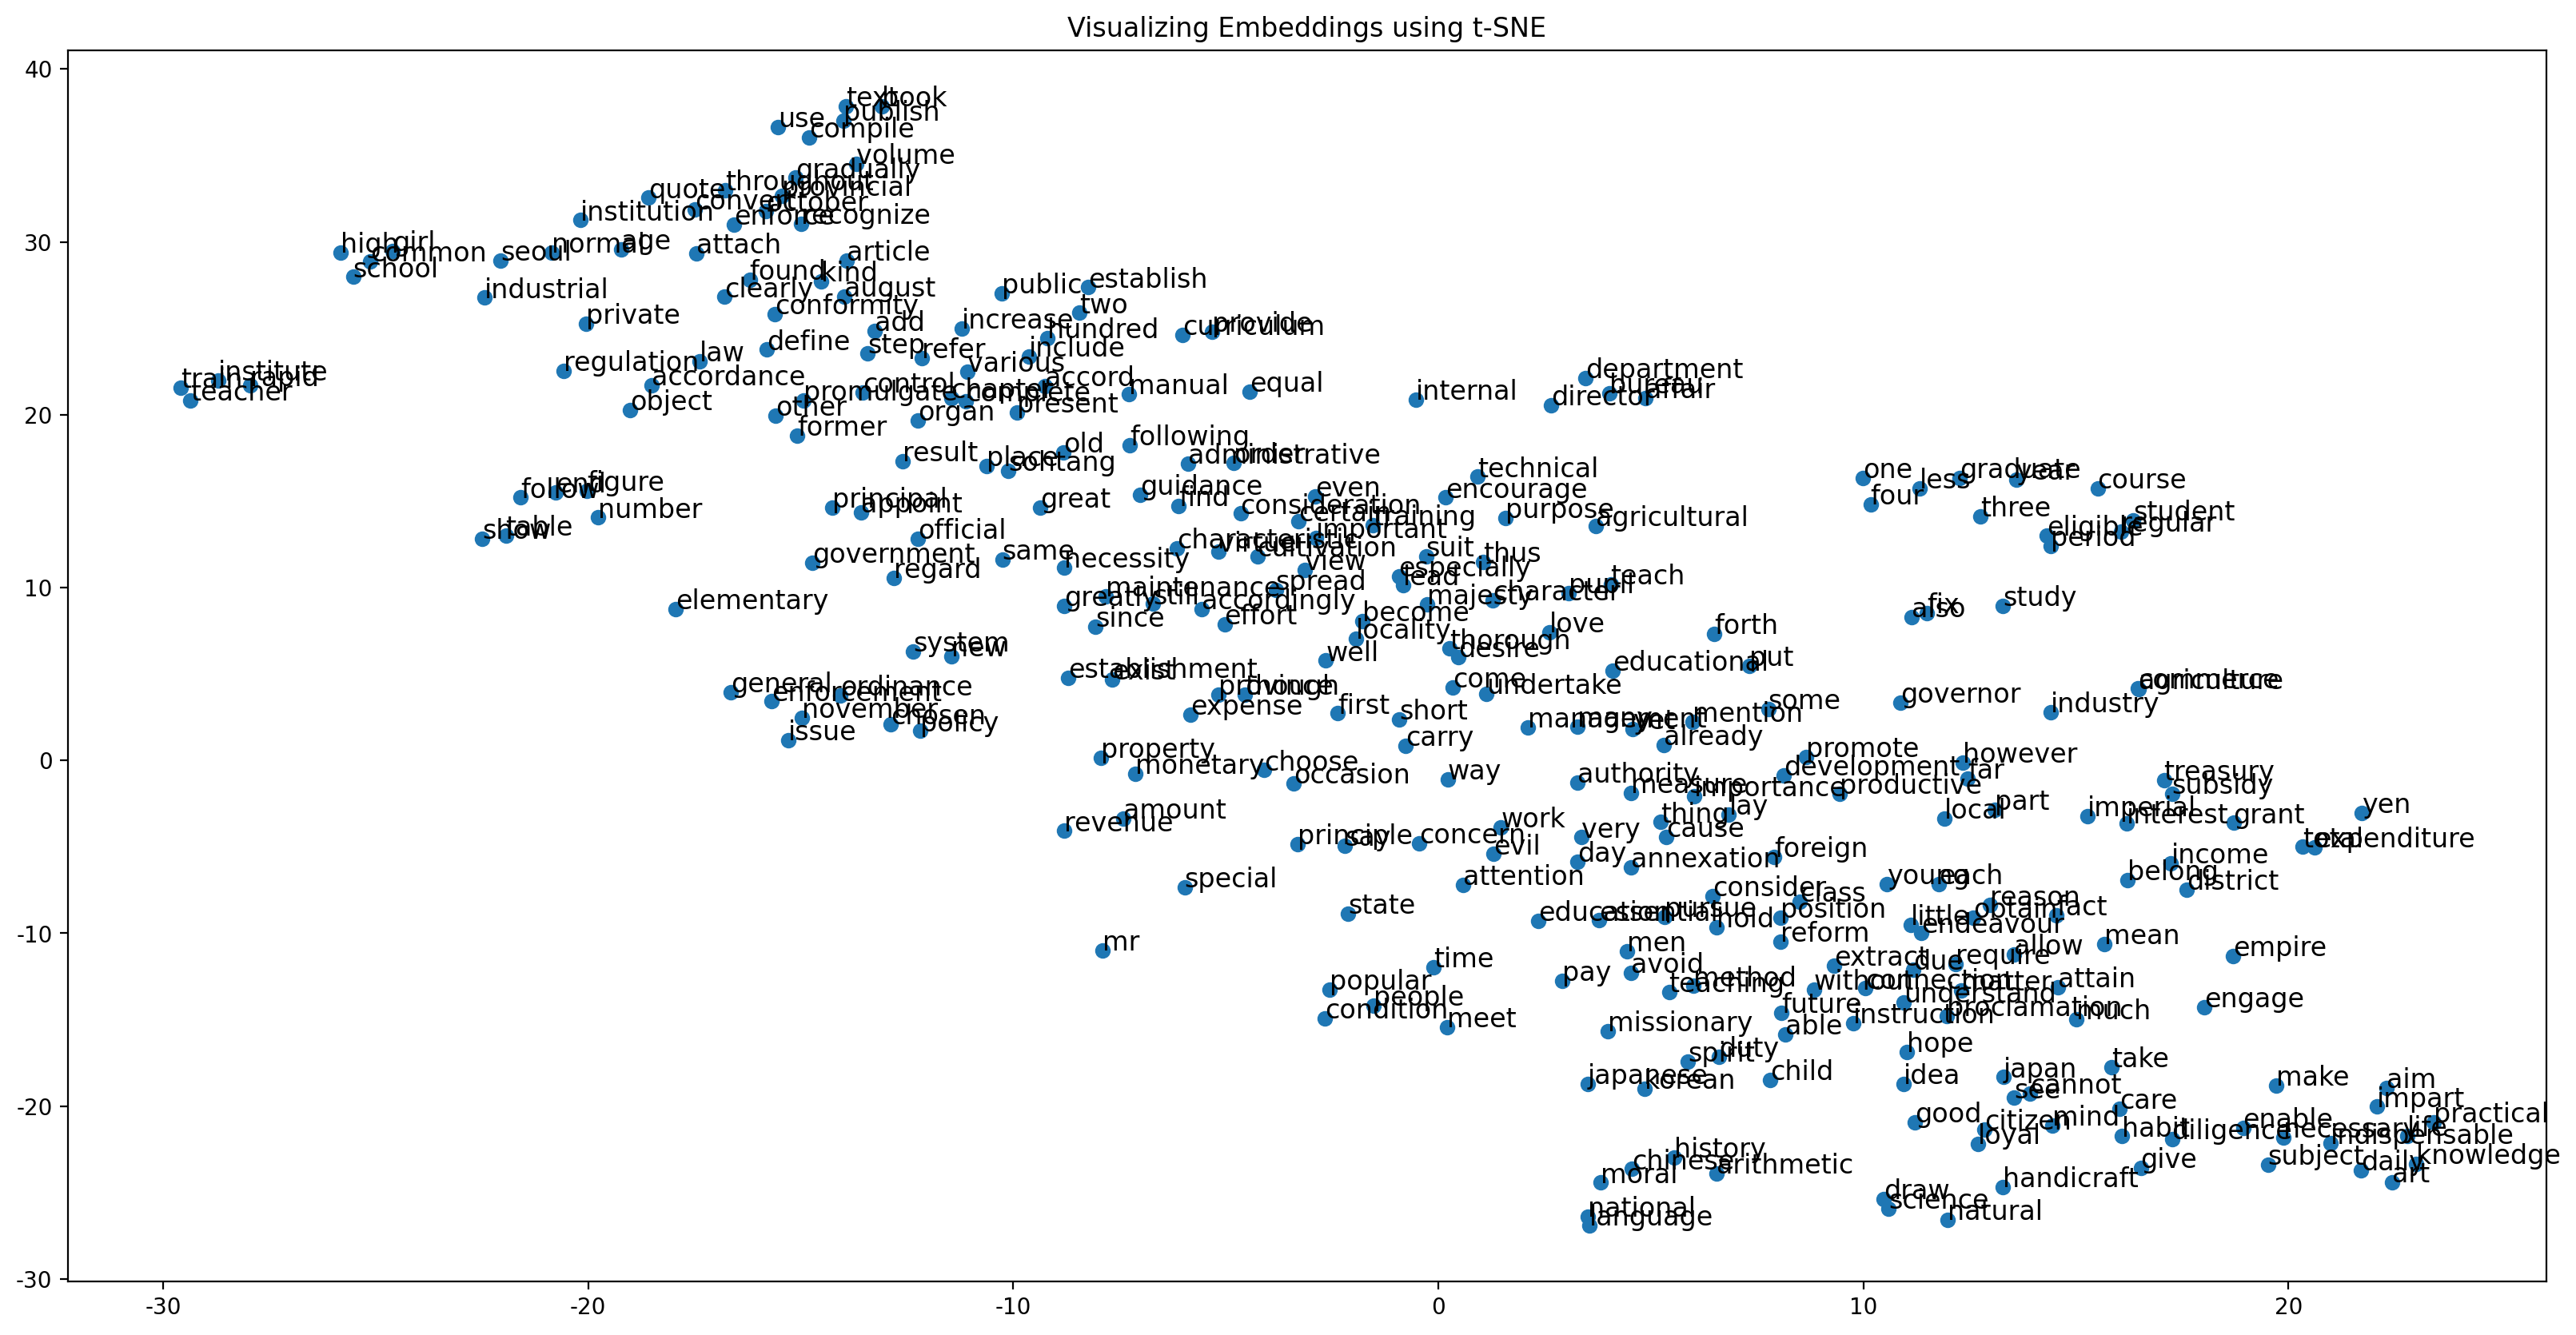

In [57]:
tsne_2d('Visualizing Embeddings using t-SNE', tsne_2d_model, X)

### 2) tsne 3차원 축소

In [58]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

In [59]:
# 3차원으로 축소하는 t-SNE 모델을 만들어줍니다.
tsne_3d_model = TSNE(perplexity=15, n_components=3, n_iter=3500, random_state=0)

In [60]:
def tsne_3d(title, tsne, X, a=1):
    # 100차원에서 3차원으로 임베딩 결과를 축소합니다.
    X_tsne = tsne.fit_transform(X)
    # 각 단어별 x,y,z좌표를 Dataframe으로 저장합니다.
    df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y', 'z'])

    # 그래프를 생성하고 출력합니다.
    %matplotlib inline
    fig = plt.figure()                      # 그래프 이미지 생성
    ax = fig.add_subplot(projection='3d')   # 3D 축 생성
    ax.scatter(df["x"], df["y"], df["z"], c='crimson', alpha=a) # 각 좌표에 점 표시
    plt.title(title)        # 제목 표시
    plt.show()              # 그래프 출력

C:\Users\User\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


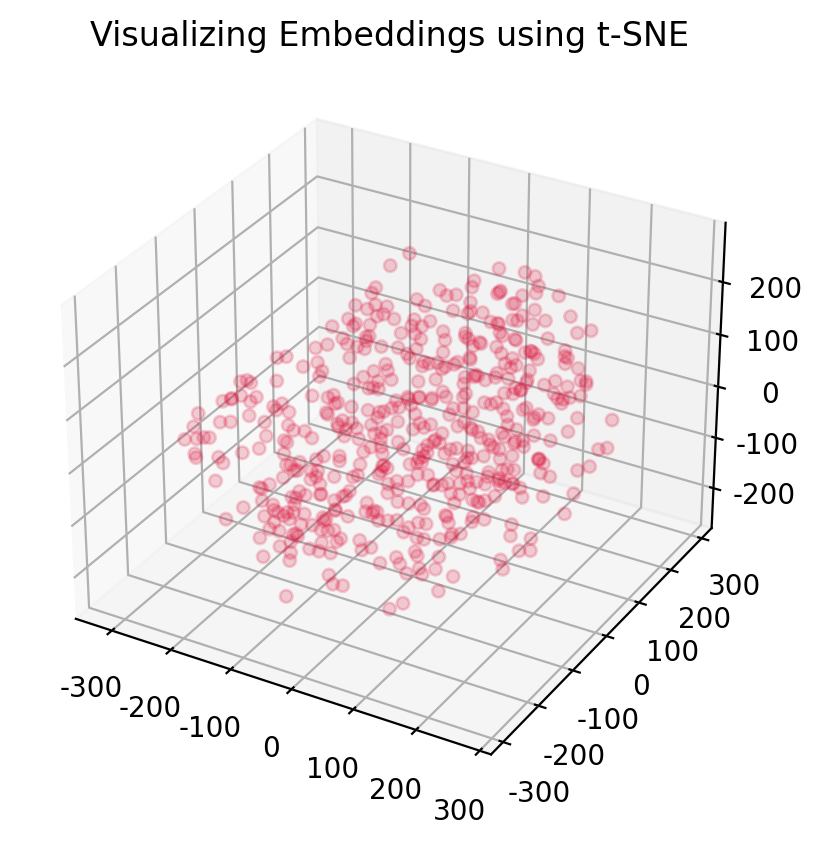

In [61]:
tsne_3d('Visualizing Embeddings using t-SNE', tsne_3d_model, X, a=0.2)

### 3) 특정 단어의 3차원 시각화

In [62]:
def tsne_3d_sample(title, words, tsne, a=1):    
    # 100차원에서 3차원으로 임베딩 결과를 축소합니다.
    X_tsne = tsne.fit_transform(X)
    # 각 단어별 x,y,z좌표를 Dataframe으로 저장합니다.
    df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y', 'z'])
    # 그래프를 생성하고 출력합니다.
    %matplotlib inline
    fig = plt.figure()                      # 그래프 이미지 생성
    ax = fig.add_subplot(projection='3d')   # 3D 축 생성
    for word in words:                      # 샘플 단어 좌표 및 주석 표시
        x = df["x"][word]
        y = df["y"][word]
        z = df["z"][word]
        ax.scatter(x, y, z, c='crimson', s=5, alpha=0.5)               
        ax.text(x, y, z, word, fontsize=7, zorder=1, alpha=a)    
    plt.title(title)    # 제목 표시
    plt.show()          # 그래프 출력

C:\Users\User\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


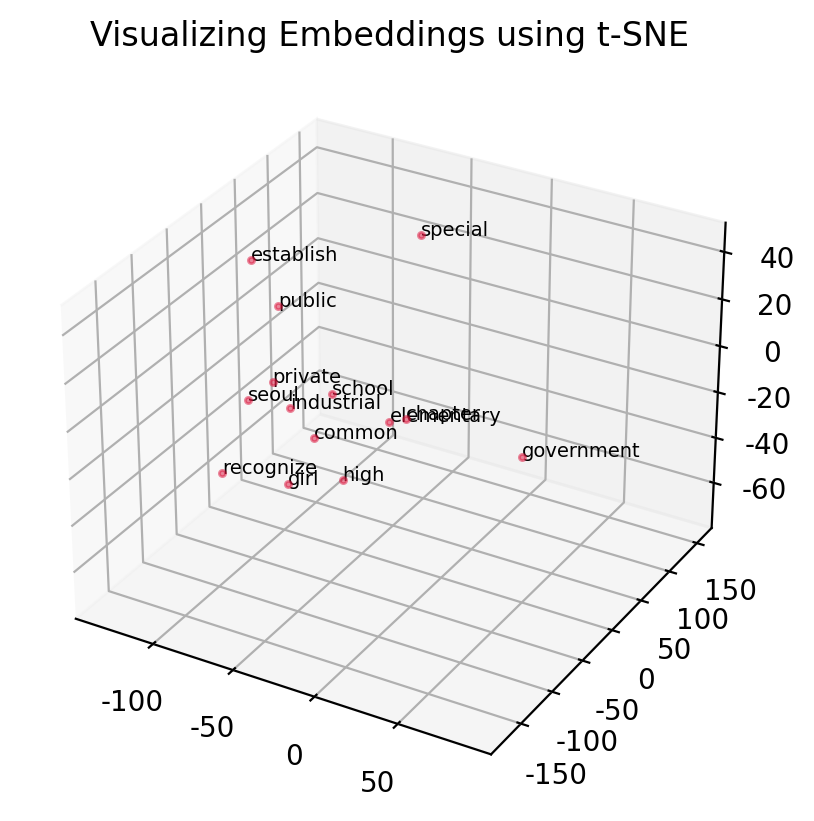

In [63]:
# 1913년도 'pyongyang' 등장하지 않음.
sample_words=['school', 'chapter', 'common', 'elementary', 'establish', 'girl', 'government', 'high', 'industrial', 
                               'private', 'public', 'recognize', 'seoul', 'special']
tsne_3d_sample('Visualizing Embeddings using t-SNE', sample_words, tsne_3d_model, a=1)